In [7]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from src.data import Observation_dataset
from src.models import UNet
import data.data_dict as data_dict

%load_ext autoreload
%autoreload 2

data = data_dict.data_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### A: Dataset and Dataloader

Shape of s2 image: torch.Size([12, 96, 96])
Shape of classes mask: torch.Size([96, 96])
Shape of rgb image: torch.Size([3, 96, 96])


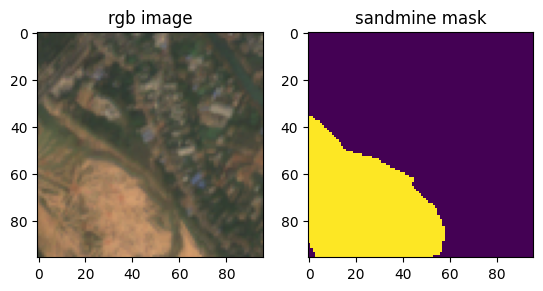

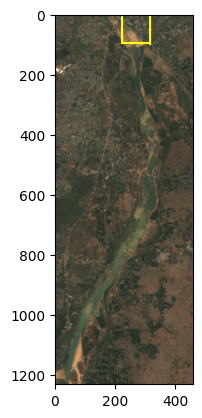

In [17]:
from src.data_utils import Observation_dataset
import matplotlib.pyplot as plt

# check shapes of dataset and locations of single image
idx = 950
ds = Observation_dataset(data[0])
s2, classes, top_left_px_idx, rgb = ds.__getitem__(idx, return_rgb=True)
print(f'Shape of s2 image: {s2.shape}')
print(f'Shape of classes mask: {classes.shape}')
print(f'Shape of rgb image: {rgb.shape}')
fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(rgb.permute(1,2,0))
axs[0].set(title='rgb image')
axs[1].matshow(classes)
axs[1].invert_yaxis
axs[1].set(title='sandmine mask')
plt.gca().xaxis.tick_bottom()
ds.visualize_batch([idx])


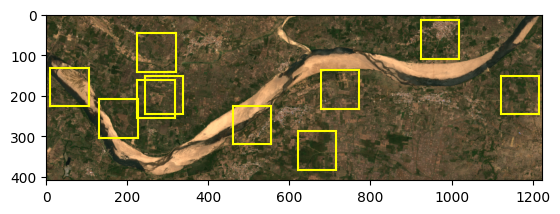

In [43]:
from torch.utils.data import DataLoader

# check uniform distribution
ds = Observation_dataset(data[1])
dl = DataLoader(ds, batch_size=10, shuffle=True)
batch = next(iter(dl))
ds.visualize_batch(batch[2])

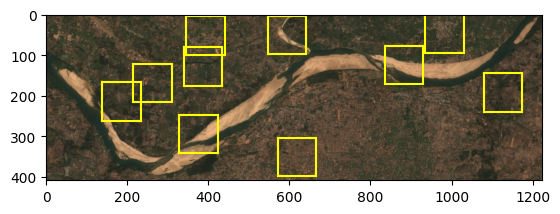

In [42]:
# check uniform distribution
ds = Observation_dataset(data[2])
dl = DataLoader(ds, batch_size=10, shuffle=True)
batch = next(iter(dl))
ds.visualize_batch(batch[2])

### B: Semantic Segmentation Training

In [6]:
# check model output shape
ds = Observation_dataset(data[1])
dl = DataLoader(ds, batch_size=7, shuffle=True)
model = UNet()

print(f'Number of parameters: {sum(param.numel() for param in model.parameters())}')
batch = next(iter(dl))
model.float()
out = UNet()(batch[0].float())
print(f'Output shape: {out.shape}')

Number parameters: 892545
Output shape: torch.Size([7, 1, 96, 96])


In [ ]:
from torch.optim import Adam
import torch.nn.modules as nn
from sklearn.metrics import accuracy_score, f1_score

# params
n_epochs = 1
batch_size = 32
device = 'cpu'

# setup
optim = Adam(model.parameters(), lr=1e-3)
loss_fct = nn.CrossEntropyLoss()

# create one dataloader for each image
train_dls = []
for d in data[:2]:
    ds = Observation_dataset(d)
    dl = DataLoader(ds, batch_size=batch_size, pin_memory=True, shuffle=True)
    train_dls.append(dl)
val_dls = []
for d in data[2:3]:
    ds = Observation_dataset(d)
    dl = DataLoader(ds, batch_size=batch_size, pin_memory=True, shuffle=False)
    val_dls.append(dl)


# main loop
model.to(device)
for epoch in range(n_epochs):

    # train
    model.train()
    for dl in train_dls:
        for batch in dl:
            
            s2, target = batch[0].to(device), batch[1].to(device)
            preds = model(batch[0])
            loss = loss_fct(preds, target)

            optim.zero_grad()
            loss.backward()
            optim.step()
        
    
    # val
    model.eval()
    with torch.zero_grad():
        for dl in val_dls:
            for batch in dl:
                s2, target = batch[0].to(device), batch[1].to(device)
                preds = model(batch[0])
                preds_binary = (preds >= 0).int()



In [ ]:
from pytorch_lightning import LightningModule

# Alternatively with Pytorch lightning
class Pl_wrapper(LightningModule):

